In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("obulisainaren/retinal-oct-c8")

print("Path to dataset files:", path)

100%|██████████| 1.42G/1.42G [01:08<00:00, 22.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/obulisainaren/retinal-oct-c8/versions/3


In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import f1_score
import numpy as np
from tqdm import tqdm

# ============================
# CONFIGURATION
# ============================
train_path = path + '/RetinalOCT_Dataset/RetinalOCT_Dataset/train'
val_path = path + '/RetinalOCT_Dataset/RetinalOCT_Dataset/val'
save_model_path = "resnet_retinal_multilabel.pth"
num_classes = 8
batch_size = 32
epochs = 10
learning_rate = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_names = ['AMD', 'CNV', 'CSR', 'DME', 'DR', 'DRUSEN', 'MH', 'NORMAL']

# ============================
# DATA TRANSFORMS
# ============================
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ============================
# DATA LOADING
# ============================
train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
val_dataset = datasets.ImageFolder(val_path, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# ============================
# MODEL (ResNet18 for Multi-label)
# ============================
class MultiLabelResNet(nn.Module):
    def __init__(self, num_classes):
        super(MultiLabelResNet, self).__init__()
        self.base = models.resnet18(pretrained=True)
        self.base.fc = nn.Linear(self.base.fc.in_features, num_classes)

    def forward(self, x):
        return self.base(x)  # raw logits

model = MultiLabelResNet(num_classes).to(device)

# ============================
# LOSS, OPTIMIZER, SCHEDULER
# ============================
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=3)

# ============================
# TRAINING FUNCTION
# ============================
def train_model():
    best_acc = 0.0
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        # ---- Training ----
        model.train()
        train_loss, correct_train, total_train = 0.0, 0, 0

        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs, labels = inputs.to(device), labels.to(device)
            labels = nn.functional.one_hot(labels, num_classes=num_classes).float()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct_train += (preds == labels).all(dim=1).sum().item()
            total_train += labels.size(0)

        avg_train_loss = train_loss / len(train_dataset)
        train_acc = correct_train / total_train

        # ---- Validation ----
        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation"):
                inputs, labels = inputs.to(device), labels.to(device)
                labels = nn.functional.one_hot(labels, num_classes=num_classes).float()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                preds = (torch.sigmoid(outputs) > 0.5).float()
                correct_val += (preds == labels).all(dim=1).sum().item()
                total_val += labels.size(0)

        avg_val_loss = val_loss / len(val_dataset)
        val_acc = correct_val / total_val

        print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

        scheduler.step(val_acc)

        # Save best model based on validation accuracy
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), save_model_path)
            print("✅ Best model saved.")

    print("Training complete.")

if __name__ == "__main__":
    train_model()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 190MB/s]



Epoch 1/10


Validation: 100%|██████████| 88/88 [00:16<00:00,  5.37it/s]


Train Loss: 0.0935 | Train Acc: 0.8584
Val Loss: 0.0466 | Val Acc: 0.9271
✅ Best model saved.

Epoch 2/10


Validation: 100%|██████████| 88/88 [00:15<00:00,  5.81it/s]


Train Loss: 0.0343 | Train Acc: 0.9465
Val Loss: 0.0246 | Val Acc: 0.9611
✅ Best model saved.

Epoch 3/10


Validation: 100%|██████████| 88/88 [00:16<00:00,  5.24it/s]


Train Loss: 0.0283 | Train Acc: 0.9572
Val Loss: 0.0248 | Val Acc: 0.9611

Epoch 4/10


Validation: 100%|██████████| 88/88 [00:15<00:00,  5.65it/s]


Train Loss: 0.0232 | Train Acc: 0.9642
Val Loss: 0.0230 | Val Acc: 0.9639
✅ Best model saved.

Epoch 5/10


Validation: 100%|██████████| 88/88 [00:15<00:00,  5.57it/s]


Train Loss: 0.0223 | Train Acc: 0.9671
Val Loss: 0.0213 | Val Acc: 0.9700
✅ Best model saved.

Epoch 6/10


Validation: 100%|██████████| 88/88 [00:15<00:00,  5.69it/s]


Train Loss: 0.0203 | Train Acc: 0.9689
Val Loss: 0.0222 | Val Acc: 0.9671

Epoch 7/10


Validation: 100%|██████████| 88/88 [00:15<00:00,  5.63it/s]


Train Loss: 0.0192 | Train Acc: 0.9703
Val Loss: 0.0228 | Val Acc: 0.9686

Epoch 8/10


Validation: 100%|██████████| 88/88 [00:15<00:00,  5.50it/s]


Train Loss: 0.0161 | Train Acc: 0.9750
Val Loss: 0.0230 | Val Acc: 0.9636

Epoch 9/10


Validation: 100%|██████████| 88/88 [00:15<00:00,  5.70it/s]


Train Loss: 0.0166 | Train Acc: 0.9755
Val Loss: 0.0238 | Val Acc: 0.9657

Epoch 10/10


Validation: 100%|██████████| 88/88 [00:15<00:00,  5.67it/s]

Train Loss: 0.0118 | Train Acc: 0.9830
Val Loss: 0.0226 | Val Acc: 0.9679
Training complete.


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Testing: 100%|██████████| 88/88 [00:18<00:00,  4.87it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report:
              precision    recall  f1-score   support

         AMD       1.00      1.00      1.00       350
         CNV       0.95      0.92      0.93       350
         CSR       1.00      1.00      1.00       350
         DME       0.95      0.95      0.95       350
          DR       1.00      1.00      1.00       350
      DRUSEN       0.94      0.95      0.94       350
          MH       1.00      1.00      1.00       350
      NORMAL       0.95      0.97      0.96       350

   micro avg       0.97      0.97      0.97      2800
   macro avg       0.97      0.97      0.97      2800
weighted avg       0.97      0.97      0.97      2800
 samples avg       0.97      0.97      0.97      2800



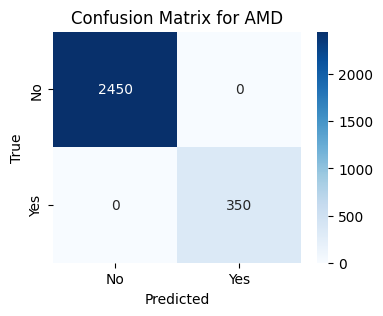

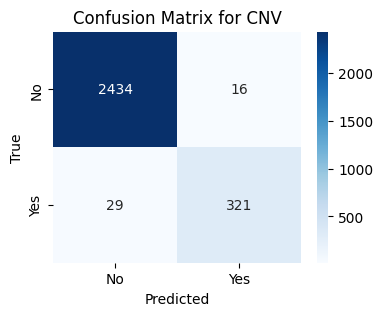

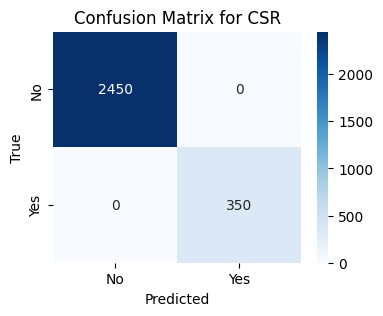

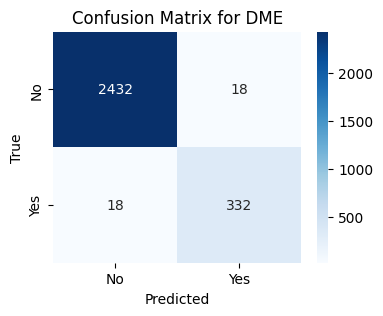

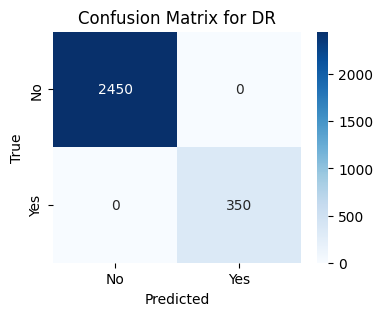

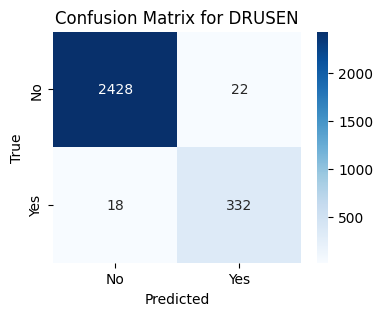

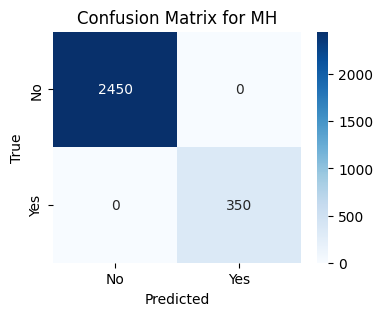

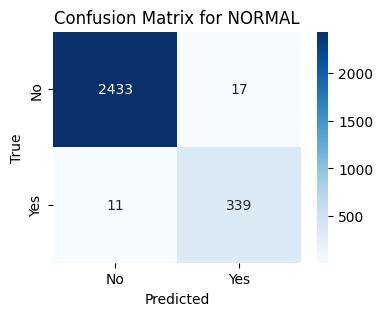

In [5]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

# ============================
# CONFIGURATION
# ============================
test_path = path + '/RetinalOCT_Dataset/RetinalOCT_Dataset/test'
model_path = "resnet_retinal_multilabel.pth"
num_classes = 8
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = ['AMD', 'CNV', 'CSR', 'DME', 'DR', 'DRUSEN', 'MH', 'NORMAL']

# ============================
# DATA TRANSFORM
# ============================
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ============================
# DATA LOADING
# ============================
test_dataset = datasets.ImageFolder(test_path, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# ============================
# MODEL LOADING
# ============================
class MultiLabelResNet(nn.Module):
    def __init__(self, num_classes):
        super(MultiLabelResNet, self).__init__()
        self.base = models.resnet18(pretrained=False)
        self.base.fc = nn.Linear(self.base.fc.in_features, num_classes)

    def forward(self, x):
        return self.base(x)

model = MultiLabelResNet(num_classes).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# ============================
# PREDICTION
# ============================
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs, labels = inputs.to(device), labels.to(device)
        labels = nn.functional.one_hot(labels, num_classes=num_classes).float()

        outputs = model(inputs)
        preds = torch.sigmoid(outputs) > 0.5

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ============================
# METRICS
# ============================
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Multi-label confusion matrix
mcm = multilabel_confusion_matrix(all_labels, all_preds)

for idx, cm in enumerate(mcm):
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix for {class_names[idx]}")
    plt.show()